Dataset: Chest X-Ray Images (Pneumonia)

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

First of all, we import all necessary libraries that we are gonna use in this model

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

this to unzip the dataset from google drive

In [ ]:
# import os

# dataset_path = '/content/drive/MyDrive/chest_xray.zip'
# extract_path = '/content/chest_xray/'

# !unzip -q "{dataset_path}" -d "{extract_path}"

now visualizing smaple images

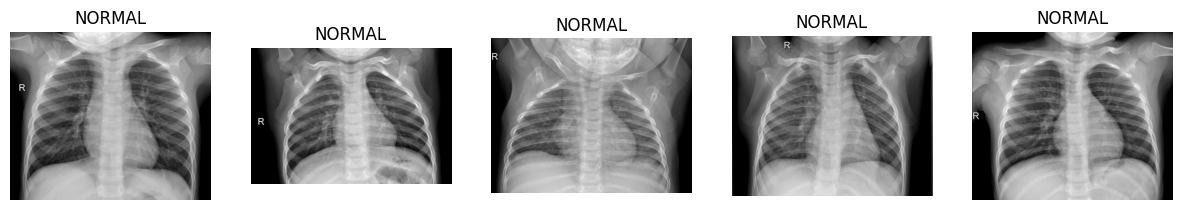

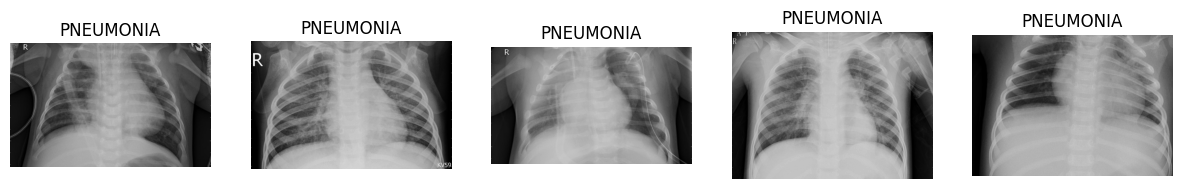

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/chest_xray/chest_xray/chest_xray/train'
val_dir = '/content/drive/MyDrive/Datasets/chest_xray/chest_xray/chest_xray/val'
test_dir = '/content/drive/MyDrive/Datasets/chest_xray/chest_xray/chest_xray/test'




def display_samples(directory, class_label, num_samples=5):
    class_path = os.path.join(directory, class_label)
    images = os.listdir(class_path)[:num_samples]
    plt.figure(figsize=(15,3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_label}")
        plt.axis('off')
    plt.show()


display_samples(train_dir, 'NORMAL')
display_samples(train_dir, 'PNEUMONIA')

this function to count images per class

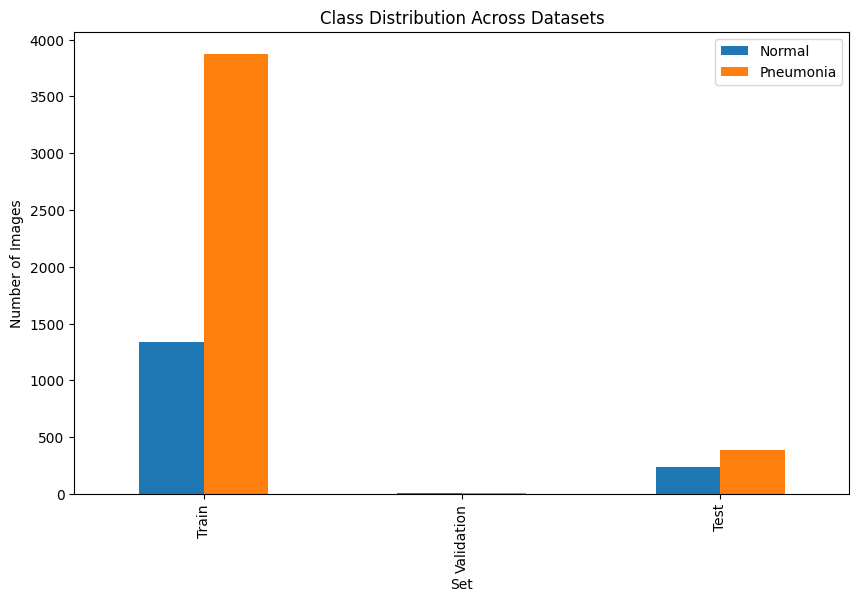

In [ ]:
def count_images(directory):

    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))     #using len() built in function
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal, pneumonia

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)


data = {
    'Set': ['Train', 'Validation', 'Test'],
    'Normal': [train_normal, val_normal, test_normal],
    'Pneumonia': [train_pneumonia, val_pneumonia, test_pneumonia]
}
df = pd.DataFrame(data)        # Create a DataFrame for visualization
df = df.set_index('Set')



# Plot class distribution


df.plot(kind='bar', figsize=(10,6))
plt.title('Class Distribution Across Datasets')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
IMAGE_SIZE = (124, 124)                  # ----- we define image size

# create a function to load images and labels

def load_data(train_directory, test_directory, image_size=IMAGE_SIZE):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    #to load training data

    for class_label in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_directory, class_label)
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

            if img is not None:

                img = cv2.resize(img, image_size)
                X_train.append(img.flatten())
                y_train.append(0 if class_label == 'NORMAL' else 1)

    #to load test data

    for class_label in ['NORMAL', 'PNEUMONIA']:

        class_path = os.path.join(test_directory, class_label)
        images = os.listdir(class_path)

        for img_name in images:

            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

            if img is not None:
                img = cv2.resize(img, image_size)
                X_test.append(img.flatten())
                y_test.append(0 if class_label == 'NORMAL' else 1)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# to load the data

X_train, y_train, X_test, y_test = load_data(train_dir, test_dir)

print(f"Training samples: {X_train.shape[0]}")

print(f"Test samples: {X_test.shape[0]}")

Training samples: 5216
Test samples: 624


we create function to load validation data

In [ ]:
def load_validation_data(validation_directory, image_size=IMAGE_SIZE):
    X_val = []
    y_val = []

    for class_label in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(validation_directory, class_label)
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, image_size)
                X_val.append(img.flatten())
                y_val.append(0 if class_label == 'NORMAL' else 1)

    return np.array(X_val), np.array(y_val)



X_val, y_val = load_validation_data(val_dir)

# Combine training and validation data

X_train = np.concatenate((X_train, X_val), axis=0)

y_train = np.concatenate((y_train, y_val), axis=0)


print(f"Combined Training samples: {X_train.shape[0]}")

Combined Training samples: 5232


here we fit the scaler on training data and transform the test data

In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

we also further split the training data into training and validation sets

In [ ]:
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_scaled, y_train, test_size=0.1, random_state=42, stratify=y_train)

print(f"Final Training samples: {X_train_final.shape[0]}")
print(f"Final Validation samples: {X_val_final.shape[0]}")

Final Training samples: 4708
Final Validation samples: 524


In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=90)


X_train_pca = pca.fit_transform(X_train_scaled)


X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 15376
Reduced number of features after PCA: 90


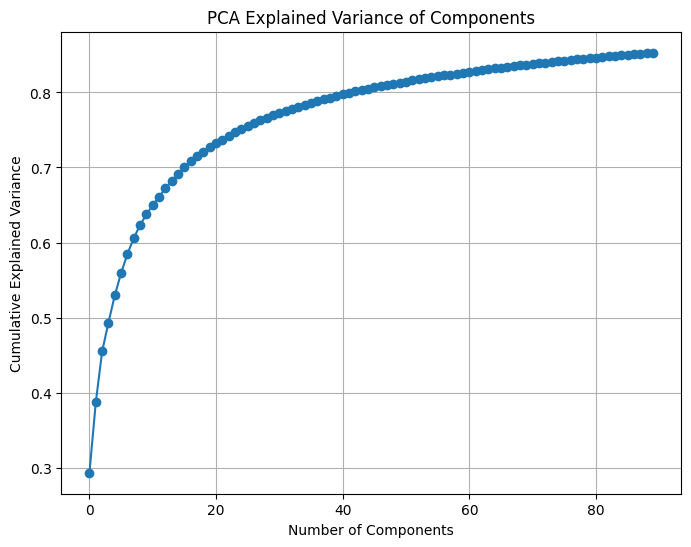

Total Explained Variance of components: 0.85


In [ ]:
# Plot the cumulative explained variance


plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance of Components')
plt.grid(True)
plt.show()



# Print total explained variance

total_variance = np.sum(pca.explained_variance_ratio_)

print(f"Total Explained Variance of components: {total_variance:.2f}")

now we perform the SVM:

In [ ]:
from sklearn.svm import SVC


svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)        # Initialize the SVM classifier with RBF kernel


svm_rbf.fit(X_train_pca, y_train)          #train the classifier on the PCA-transformed training data

SVC(C=10, random_state=42)

Predict on the test data

In [ ]:
y_pred = svm_rbf.predict(X_test_pca)

Calculate accuracy:

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.40%


Generate classification report:

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia'])

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.41      0.58       234
   Pneumonia       0.74      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.71       624
weighted avg       0.82      0.77      0.75       624



Confusion Matrix:

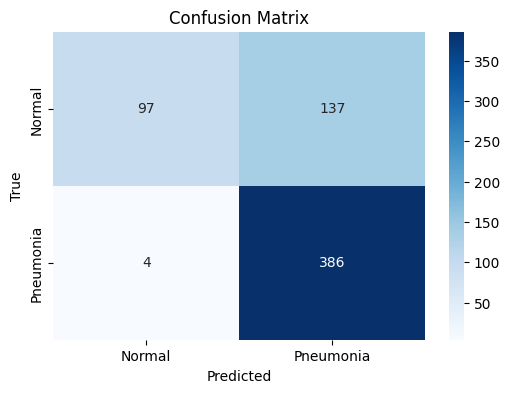

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

5-fold cross-validation on the SVM

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# now performing 5-fold cross-validation on the SVM

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(svm_rbf, X_train_pca, y_train, cv=skf, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")

print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")

print(f"Standard Deviation: {cv_scores.std() * 100:.2f}%")

Cross-Validation Accuracy Scores: [0.9608405  0.96943649 0.97131931 0.97418738 0.97609943]
Mean CV Accuracy: 97.04%
Standard Deviation: 0.53%
